In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Load the dataset (replace 'updated.csv' with your file path)
df = pd.read_csv('updated.csv')

# Display the first few rows
df.head()

,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,1,0x4607_x,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,11:30,11:45,4,0,2,3,3,0.0,1,3,24.0
1,2,0xb379_x,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,19:45,19:50,3,1,2,3,4,1.0,1,1,33.0
2,3,0x20f7_x,BANGRES18DEL01,37,4.4,12.913041,77.683237,12.953041,77.723237,13:50,13:55,6,0,0,0,3,2.0,1,1,42.0
3,4,0x7804_x,HYDRES13DEL02,28,4.9,17.431477,78.400350,17.451477,78.420350,10:60,11:15,2,2,1,2,4,1.0,1,3,19.0
4,5,0x7faf_x,RANCHIRES07DEL01,37,4.6,23.359407,85.325055,23.429407,85.395055,23:50,23:60,3,2,0,2,3,1.0,1,1,25.0


In [3]:
# Fix missing or invalid values
df['Delivery_person_Age'] = df['Delivery_person_Age'].replace(0, np.nan)  # Replace 0 with NaN
df['Delivery_person_Ratings'] = pd.to_numeric(df['Delivery_person_Ratings'], errors='coerce')  # Convert to numeric, blank to NaN
df['multiple_deliveries'] = df['multiple_deliveries'].fillna(0)  # Assume 0 if missing

# Fix invalid time formats (e.g., "10:60" -> "11:00")
def fix_time(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        hours, minutes = map(int, time_str.split(':'))
        if minutes >= 60:
            hours += 1
            minutes -= 60
        return f"{hours:02d}:{minutes:02d}"
    except:
        return np.nan

df['Time_Orderd'] = df['Time_Orderd'].apply(fix_time)
df['Time_Order_picked'] = df['Time_Order_picked'].apply(fix_time)

# Handle missing coordinates (replace 0.0 with NaN)
df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']] = \
    df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']].replace(0.0, np.nan)

# Drop rows with critical missing values (e.g., target or coordinates)
df = df.dropna(subset=['Time_taken(min)', 'Restaurant_latitude', 'Delivery_location_latitude'])

# Display cleaned data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2266 entries, 0 to 2440
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   2266 non-null   int64  
 1   ID                           2266 non-null   object 
 2   Delivery_person_ID           2266 non-null   object 
 3   Delivery_person_Age          2180 non-null   float64
 4   Delivery_person_Ratings      2179 non-null   float64
 5   Restaurant_latitude          2266 non-null   float64
 6   Restaurant_longitude         2266 non-null   float64
 7   Delivery_location_latitude   2266 non-null   float64
 8   Delivery_location_longitude  2266 non-null   float64
 9   Time_Orderd                  2185 non-null   object 
 10  Time_Order_picked            2266 non-null   object 
 11  Weatherconditions            2266 non-null   int64  
 12  Road_traffic_density         2266 non-null   int64  
 13  Vehicle_condition      

In [4]:
# Calculate Haversine distance between restaurant and delivery location (in kilometers)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df['Distance_km'] = df.apply(
    lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'],
                          row['Delivery_location_latitude'], row['Delivery_location_longitude']),
    axis=1
)

# Calculate pickup delay (in minutes)
def time_to_minutes(time_str):
    if pd.isna(time_str):
        return np.nan
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

df['Order_Time_Min'] = df['Time_Orderd'].apply(time_to_minutes)
df['Pickup_Time_Min'] = df['Time_Order_picked'].apply(time_to_minutes)
df['Pickup_Delay'] = df['Pickup_Time_Min'] - df['Order_Time_Min']

# Handle negative delays (e.g., crossing midnight)
df['Pickup_Delay'] = df['Pickup_Delay'].apply(lambda x: x if x >= 0 else x + 1440)

# Extract hour of day from order time
df['Hour_of_Day'] = df['Order_Time_Min'].apply(lambda x: int(x / 60) if not pd.isna(x) else np.nan)

# Interaction feature: Age * Rating
df['Age_Rating_Interaction'] = df['Delivery_person_Age'] * df['Delivery_person_Ratings']

# Fill remaining NaNs with median values
df['Delivery_person_Age'] = df['Delivery_person_Age'].fillna(df['Delivery_person_Age'].median())
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median())
df['Pickup_Delay'] = df['Pickup_Delay'].fillna(df['Pickup_Delay'].median())
df['Hour_of_Day'] = df['Hour_of_Day'].fillna(df['Hour_of_Day'].median())

# Display new features
df[['Distance_km', 'Pickup_Delay', 'Hour_of_Day', 'Age_Rating_Interaction']].head()

,Distance_km,Pickup_Delay,Hour_of_Day,Age_Rating_Interaction
0,3.025149,15.0,11.0,181.3
1,20.183530,5.0,19.0,153.0
2,6.210864,5.0,13.0,162.8
3,3.073618,15.0,11.0,137.2
4,10.564974,10.0,23.0,170.2


In [5]:
# Select features and target
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_km', 'Pickup_Delay', 'Hour_of_Day',
            'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
            'multiple_deliveries', 'Festival', 'City', 'Age_Rating_Interaction']
target = 'Time_taken(min)'

# Drop rows with NaN in features or target
df_model = df[features + [target]].dropna()

# Split into features (X) and target (y)
X = df_model[features]
y = df_model[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (1743, 14)
Test set shape: (436, 14)


In [6]:
# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")
print(f"R-squared (R2): {r2:.2f}")

Root Mean Squared Error (RMSE): 4.21 minutes
R-squared (R2): 0.78


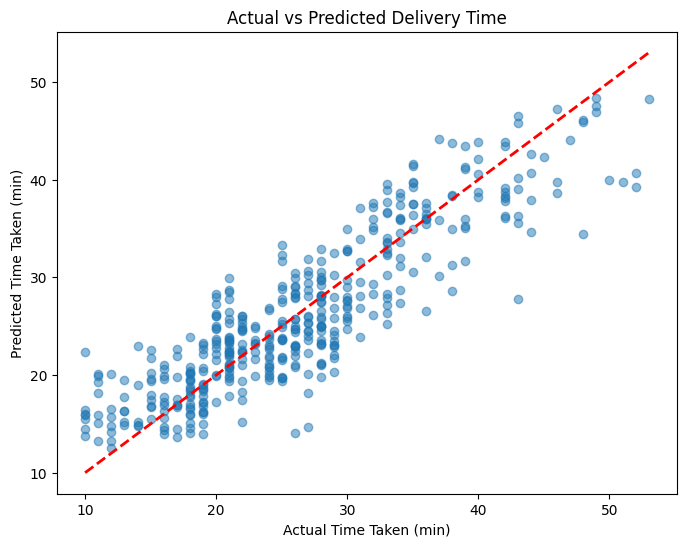

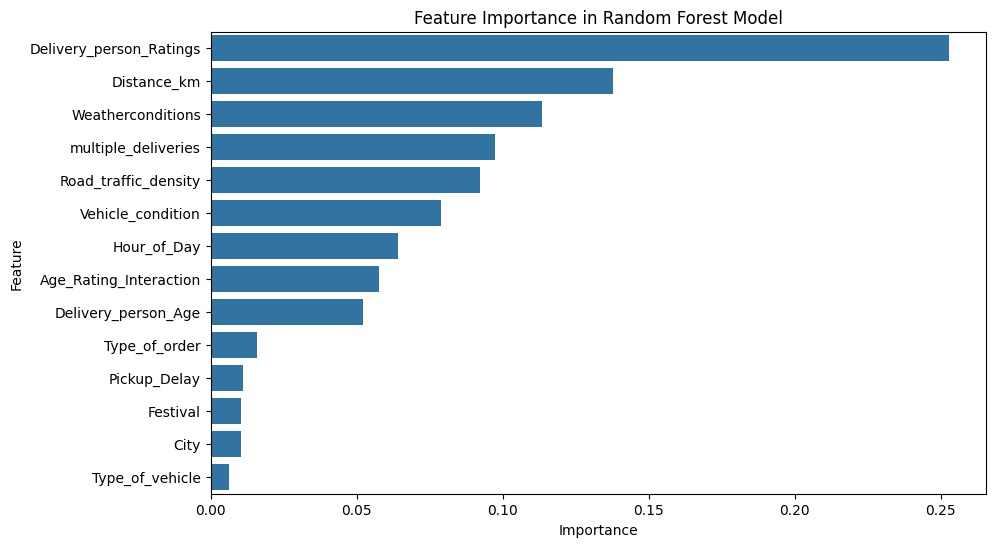

In [7]:
# Scatter plot of actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Time Taken (min)')
plt.ylabel('Predicted Time Taken (min)')
plt.title('Actual vs Predicted Delivery Time')
plt.show()

# Feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance in Random Forest Model')
plt.show()

In [8]:
# Example: Predict for a single row (e.g., first row of test set)
example = X_test.iloc[0].values.reshape(1, -1)
predicted_time = rf_model.predict(example)[0]
actual_time = y_test.iloc[0]

print("Example Prediction:")
print(f"Predicted Time: {predicted_time:.2f} minutes")
print(f"Actual Time: {actual_time:.2f} minutes")

Example Prediction:
Predicted Time: 14.10 minutes
Actual Time: 18.00 minutes


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


RMSE: 4.21 minutes
R-squared: 0.78


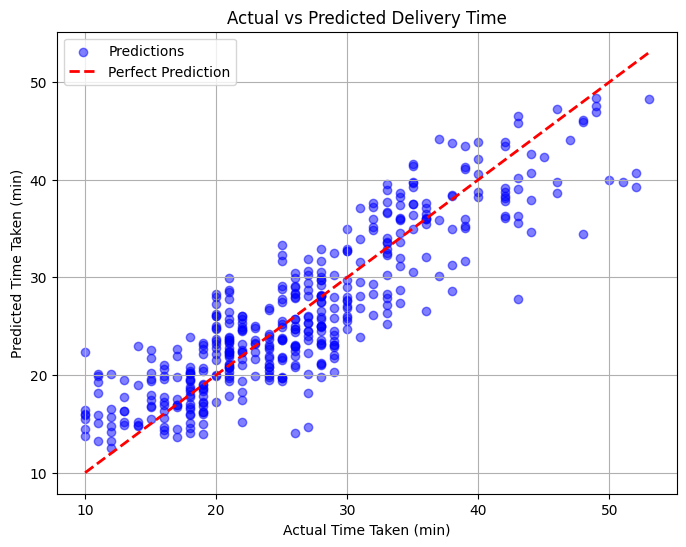

<ipython-input-9-52e77b1fad3c>:108: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


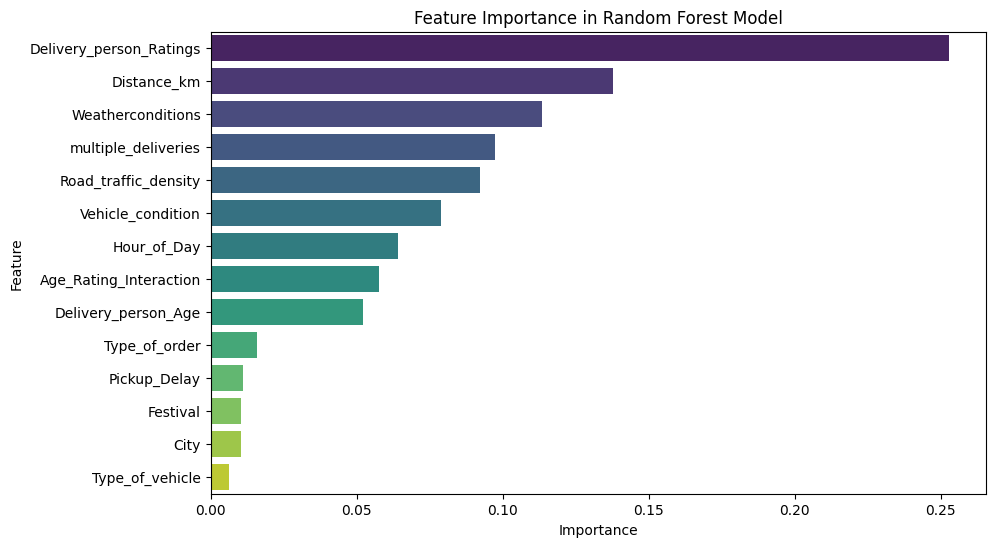

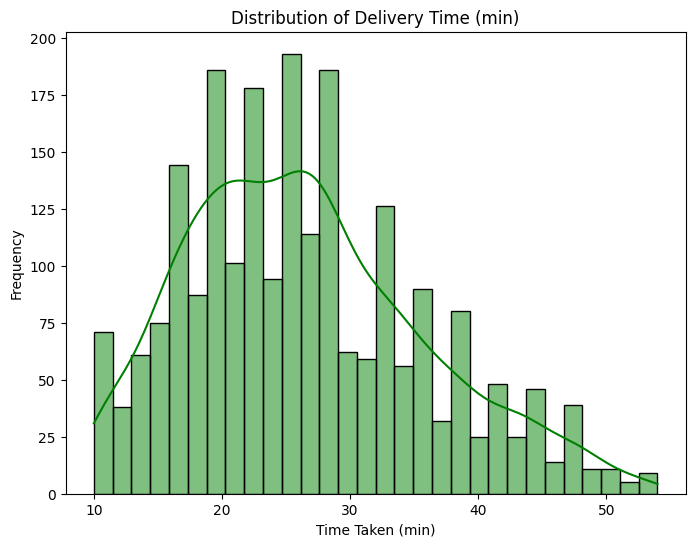

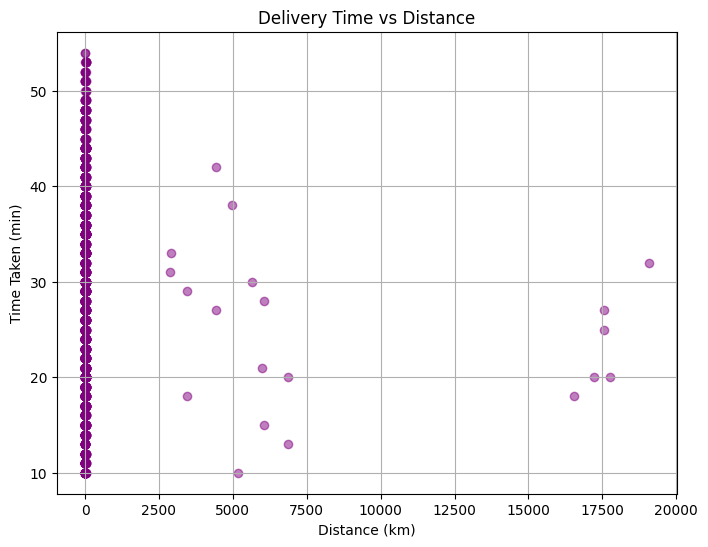

<ipython-input-9-52e77b1fad3c>:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df, palette='coolwarm')


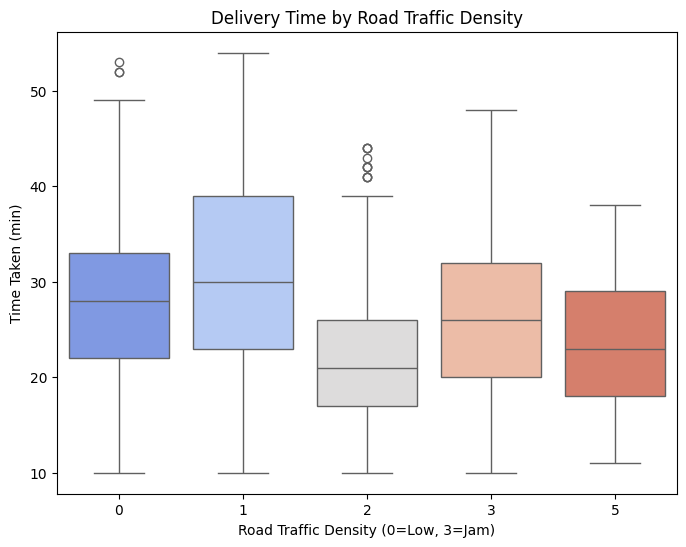

<ipython-input-9-52e77b1fad3c>:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df, palette='Set2')


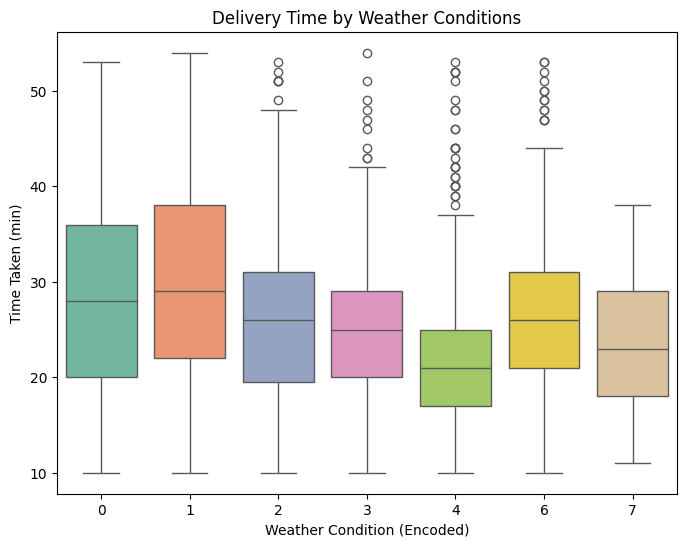

In [9]:
# Import libraries
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

# Load dataset
df = pd.read_csv('updated.csv')

# Data cleaning
df['Delivery_person_Age'] = df['Delivery_person_Age'].replace(0, np.nan)
df['Delivery_person_Ratings'] = pd.to_numeric(df['Delivery_person_Ratings'], errors='coerce')
df['multiple_deliveries'] = df['multiple_deliveries'].fillna(0)

def fix_time(time_str):
    if pd.isna(time_str):
        return np.nan
    try:
        hours, minutes = map(int, time_str.split(':'))
        if minutes >= 60:
            hours += 1
            minutes -= 60
        return f"{hours:02d}:{minutes:02d}"
    except:
        return np.nan

df['Time_Orderd'] = df['Time_Orderd'].apply(fix_time)
df['Time_Order_picked'] = df['Time_Order_picked'].apply(fix_time)
df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']] = \
    df[['Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude', 'Delivery_location_longitude']].replace(0.0, np.nan)
df = df.dropna(subset=['Time_taken(min)', 'Restaurant_latitude', 'Delivery_location_latitude'])

# Feature engineering
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return R * c

df['Distance_km'] = df.apply(
    lambda row: haversine(row['Restaurant_latitude'], row['Restaurant_longitude'],
                          row['Delivery_location_latitude'], row['Delivery_location_longitude']),
    axis=1
)

def time_to_minutes(time_str):
    if pd.isna(time_str):
        return np.nan
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes

df['Order_Time_Min'] = df['Time_Orderd'].apply(time_to_minutes)
df['Pickup_Time_Min'] = df['Time_Order_picked'].apply(time_to_minutes)
df['Pickup_Delay'] = df['Pickup_Time_Min'] - df['Order_Time_Min']
df['Pickup_Delay'] = df['Pickup_Delay'].apply(lambda x: x if x >= 0 else x + 1440)
df['Hour_of_Day'] = df['Order_Time_Min'].apply(lambda x: int(x / 60) if not pd.isna(x) else np.nan)
df['Age_Rating_Interaction'] = df['Delivery_person_Age'] * df['Delivery_person_Ratings']
df['Delivery_person_Age'] = df['Delivery_person_Age'].fillna(df['Delivery_person_Age'].median())
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median())
df['Pickup_Delay'] = df['Pickup_Delay'].fillna(df['Pickup_Delay'].median())
df['Hour_of_Day'] = df['Hour_of_Day'].fillna(df['Hour_of_Day'].median())

# Prepare data for modeling
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Distance_km', 'Pickup_Delay', 'Hour_of_Day',
            'Weatherconditions', 'Road_traffic_density', 'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
            'multiple_deliveries', 'Festival', 'City', 'Age_Rating_Interaction']
target = 'Time_taken(min)'
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f} minutes")
print(f"R-squared: {r2:.2f}")

# Graphs
# 1. Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Time Taken (min)')
plt.ylabel('Predicted Time Taken (min)')
plt.title('Actual vs Predicted Delivery Time')
plt.legend()
plt.grid(True)
plt.show()

# 2. Feature Importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# 3. Distribution of Delivery Time
plt.figure(figsize=(8, 6))
sns.histplot(df['Time_taken(min)'], bins=30, kde=True, color='green')
plt.title('Distribution of Delivery Time (min)')
plt.xlabel('Time Taken (min)')
plt.ylabel('Frequency')
plt.show()

# 4. Delivery Time vs Distance
plt.figure(figsize=(8, 6))
plt.scatter(df['Distance_km'], df['Time_taken(min)'], alpha=0.5, color='purple')
plt.title('Delivery Time vs Distance')
plt.xlabel('Distance (km)')
plt.ylabel('Time Taken (min)')
plt.grid(True)
plt.show()

# 5. Delivery Time by Road Traffic Density
plt.figure(figsize=(8, 6))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df, palette='coolwarm')
plt.title('Delivery Time by Road Traffic Density')
plt.xlabel('Road Traffic Density (0=Low, 3=Jam)')
plt.ylabel('Time Taken (min)')
plt.show()

# 6. Delivery Time by Weather Conditions
plt.figure(figsize=(8, 6))
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df, palette='Set2')
plt.title('Delivery Time by Weather Conditions')
plt.xlabel('Weather Condition (Encoded)')
plt.ylabel('Time Taken (min)')
plt.show()